### Improved CNN for FT of MNIST data. Also padded size.

### v3 introduces 2 channels of intensity and phase to see if accuracy improves

In [1]:
#Choose GPUs and CPUs

import tensorflow as tf
import keras
from keras import backend as K
from keras.datasets import mnist

#If want to choose GPU to use
#This will make it so that only the 0th GPU is visible to TensorFlow.
#In your case, you can choose any in the range [0, 3].
#If you wanted, for example, the 0th and 2nd GPUs to both be visible, replace "0" with "0,2"
import os
os.environ["CUDA_VISIBLE_DEVICES"]="0,1"

GPU=True
CPU=False
num_cores = 8

if GPU:
    num_GPU = 2
    num_CPU = 2
if CPU:
    num_CPU = num_cores
    num_GPU = 0

config = tf.ConfigProto(intra_op_parallelism_threads=num_cores,\
        inter_op_parallelism_threads=num_cores, allow_soft_placement=True,\
        device_count = {'CPU' : num_CPU, 'GPU' : num_GPU},\
#        gpu_options=tf.GPUOptions(per_process_gpu_memory_fraction=0.5))
                       )
config.gpu_options.allow_growth = True

session = tf.Session(config=config)
K.set_session(session)


Using TensorFlow backend.


In [2]:
from __future__ import print_function
import matplotlib.pyplot as plt
import numpy as np
from six.moves.urllib.request import urlretrieve
from six.moves import cPickle as pickle


from keras.layers import Conv2D, MaxPool2D
from keras.models import Sequential, Model
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.utils import to_categorical, multi_gpu_model

from tqdm import tqdm_notebook, tnrange

from scipy.fftpack import fftn,fftshift
#from skimage.restoration import unwrap_phase


# Config the matplotlib backend as plotting inline in IPython
%matplotlib inline

# Load MNIST data from Keras

In [3]:

# input image dimensions
img_rows, img_cols = 28, 28
num_classes=10

# the data, split between train and test sets
(x_train, y_train), (x_test, y_test) = mnist.load_data()

if K.image_data_format() == 'channels_first':
    x_train = x_train.reshape(x_train.shape[0], 1, img_rows, img_cols)
    x_test = x_test.reshape(x_test.shape[0], 1, img_rows, img_cols)
    input_shape = (1, img_rows, img_cols)
else:
    x_train = x_train.reshape(x_train.shape[0], img_rows, img_cols, 1)
    x_test = x_test.reshape(x_test.shape[0], img_rows, img_cols, 1)
    input_shape = (img_rows, img_cols, 1)

train_dataset = x_train.astype('float32')
test_dataset = x_test.astype('float32')
train_dataset /= 255
test_dataset /= 255
print('train_dataset shape:', x_train.shape)
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')

# convert class vectors to binary class matrices
train_labels = keras.utils.to_categorical(y_train, num_classes)
test_labels = keras.utils.to_categorical(y_test, num_classes)


train_dataset shape: (60000, 28, 28, 1)
60000 train samples
10000 test samples


# Pad numpy array 
Want get 36x36 which is how much the multiMNIST will be

In [4]:
train_dataset=np.pad(train_dataset, ((0,0),(4,4),(4,4),(0,0)), 'constant', constant_values=(0,0))
print (train_dataset.shape)

test_dataset=np.pad(test_dataset, ((0,0),(4,4),(4,4),(0,0)), 'constant', constant_values=(0,0))
print (test_dataset.shape)

(60000, 36, 36, 1)
(10000, 36, 36, 1)


# FT the training and test data

In [5]:
dims=train_dataset.shape
ft_train=np.zeros((dims[0], 36, 36, 2), float)
for i in tnrange(dims[0]):
    ft_train[i,:,:,0]=np.abs(fftshift(fftn(train_dataset[i,:,:]))).squeeze()
    ft_train[i,:,:,1]=np.angle(fftshift(fftn(train_dataset[i,:,:]))).squeeze()
#    ft_train[i,:,:,1]=unwrap_phase(ft_train[i,:,:,1])

dims=test_dataset.shape
ft_test=np.zeros((dims[0], 36, 36, 2), float)
for i in tqdm_notebook(range(dims[0])):
    ft_test[i,:,:,0]=np.abs(fftshift(fftn(test_dataset[i,:,:]))).squeeze()
    ft_test[i,:,:,1]=np.angle(fftshift(fftn(test_dataset[i,:,:]))).squeeze()
#    ft_test[i,:,:,1]=unwrap_phase(ft_test[i,:,:,1])

print (ft_train.shape)
print (ft_test.shape)

/home/mcherukara/miniconda3/envs/gpu/lib/python3.6/site-packages/scipy/fftpack/basic.py:160: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  z[index] = x



(60000, 36, 36, 2)
(10000, 36, 36, 2)


<Figure size 432x288 with 0 Axes>

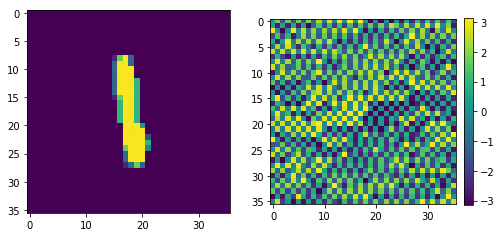

In [6]:
i=200
plt.viridis()
f,axarr=plt.subplots(1,2,figsize=(8, 6))
axarr[0].imshow(np.abs(train_dataset[i].squeeze()))
img=axarr[1].imshow(ft_train[i,:,:,1].squeeze())
#from skimage.restoration import unwrap_phase
#tmp=unwrap_phase(ft_train[i,:,:,1].squeeze())
#img=axarr[1].imshow(tmp)
f.colorbar(img, fraction=0.046, pad=0.04)

# O.K now try CNN

In [7]:
class ModelMGPU(Model):
    def __init__(self, ser_model, gpus):
        pmodel = multi_gpu_model(ser_model, gpus)
        self.__dict__.update(pmodel.__dict__)
        self._smodel = ser_model

    def __getattribute__(self, attrname):
        '''Override load and save methods to be used from the serial-model. The
        serial-model holds references to the weights in the multi-gpu model.
        '''
        # return Model.__getattribute__(self, attrname)
        if 'load' in attrname or 'save' in attrname:
            return getattr(self._smodel, attrname)

        return super(ModelMGPU, self).__getattribute__(attrname)

In [8]:
dims=ft_train.shape
print (dims)
trainee=ft_train.reshape(dims[0],dims[1],dims[2],2)
dims=test_dataset.shape
testee=ft_test.reshape(dims[0],dims[1],dims[2],2)
print (trainee.shape)

w_size=3

np.random.seed(123)
model=Sequential()

model.add(Conv2D(32,(w_size,w_size), activation='relu', input_shape=(36,36,2),
                     data_format='channels_last', padding='same'))
model.add(Conv2D(32,(w_size,w_size), activation='relu', padding='same'))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Conv2D(64,(w_size,w_size), activation='relu', padding='same'))
model.add(Conv2D(64,(w_size,w_size), activation='relu', padding='same'))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Conv2D(128,(w_size,w_size), activation='relu', padding='same'))
model.add(Conv2D(128,(w_size,w_size), activation='relu', padding='same'))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Flatten())
model.add(Dense(600, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(10, activation='sigmoid')) 

parallel_model = ModelMGPU(model, gpus=num_GPU)
parallel_model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

#print (model.summary())
print (parallel_model.summary())



checkpoints=keras.callbacks.ModelCheckpoint('ft_models/weights.{epoch:02d}.hdf5', 
                                            monitor='val_loss', verbose=1, 
                                            save_best_only=False, 
                                            save_weights_only=False, 
                                            mode='auto', period=1)

history=parallel_model.fit(trainee, train_labels, batch_size=256, verbose=1, epochs=10, 
                  validation_split = 0.1, callbacks=[checkpoints])

(60000, 36, 36, 2)
(60000, 36, 36, 2)
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
conv2d_1_input (InputLayer)     (None, 36, 36, 2)    0                                            
__________________________________________________________________________________________________
lambda_1 (Lambda)               (None, 36, 36, 2)    0           conv2d_1_input[0][0]             
__________________________________________________________________________________________________
lambda_2 (Lambda)               (None, 36, 36, 2)    0           conv2d_1_input[0][0]             
__________________________________________________________________________________________________
sequential_1 (Sequential)       (None, 10)           1522130     lambda_1[0][0]                   
                                                                 lambda

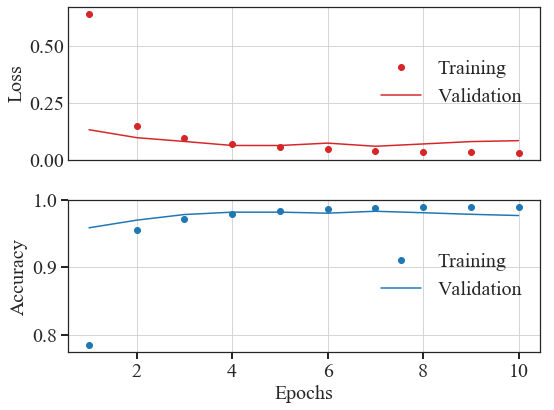

In [55]:
hist=history
epochs=np.asarray(history.epoch)+1

%matplotlib inline
import matplotlib
plt.style.use('seaborn-white')
matplotlib.rc('font',family='Times New Roman')
matplotlib.rcParams['font.size'] = 20

f, axarr = plt.subplots(2, sharex=True, figsize=(8, 6))

axarr[0].set(ylabel='Loss')
axarr[0].plot(epochs,hist.history['loss'], 'C3o', label='Training')
axarr[0].plot(epochs,hist.history['val_loss'], 'C3-', label='Validation')
axarr[0].grid()
axarr[0].legend(loc='center right', bbox_to_anchor=(1.0, 0.5))


axarr[1].plot(epochs,hist.history['acc'], 'C0o', label='Training')
axarr[1].plot(epochs,hist.history['val_acc'], 'C0-', label='Validation')
plt.legend(loc='center right', bbox_to_anchor=(1.0, 0.5))
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.tight_layout()
plt.grid()
plt.tick_params(which='both', width=2)
plt.tick_params(which='major', length=7)
plt.tick_params(which='minor', length=5)

In [56]:
from keras.models import Model, load_model
model=load_model('ft_models/weights.06.hdf5') #Numbering starts from 0
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
score=model.evaluate(testee, test_labels, verbose=1)
print (score)

 9728/10000 [============================>.] - ETA: 0s[0.06683168837108242, 0.9811]


In [57]:
preds=(model.predict(testee))

6


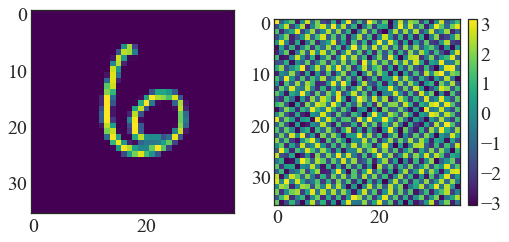

In [58]:
i=100
f,axarr=plt.subplots(1,2,figsize=(8, 6))
axarr[0].imshow(test_dataset[i].squeeze(),cmap='viridis')
img=axarr[1].imshow(testee[i,:,:,1].squeeze(), cmap='viridis')
plt.colorbar(img, fraction=0.046, pad=0.04)
print (np.argmax(preds[i]))